In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns

In [3]:
df = pd.read_csv("data library/Soja_v1.csv", sep=";")
df = df.sort_values(by="Data")
df = df.reset_index(drop=True)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0


EDA

In [4]:
df.describe()

,Estadual,País,Id,Último,Abertura,Máxima,Mínima
count,246.000000,246.000000,246.0,246.000000,246.000000,246.000000,246.000000
mean,67.186526,70.990513,0.0,36643.680980,36282.400678,29087.409073,44939.269597
std,42.222066,42.764842,0.0,42034.357061,41964.475156,40357.496000,42329.163433
min,17.383800,22.010400,0.0,1.005100,1.000000,1.003120,0.000000
25%,37.853025,41.142300,0.0,1.282005,1.272722,1.230345,1.298625
50%,55.675250,60.098450,0.0,1.526250,1.521940,1.488190,55375.000000
75%,74.322025,76.874025,0.0,86818.750000,86609.750000,69531.250000,87247.000000
max,179.294900,191.998900,0.0,99975.000000,99675.000000,99988.000000,99563.000000


In [5]:
df[["Estadual", "País", "Último", "Abertura", "Máxima", "Mínima"]].corr()

,Estadual,País,Último,Abertura,Máxima,Mínima
Estadual,1.000000,0.996817,-0.345821,-0.346514,-0.303262,-0.375623
País,0.996817,1.000000,-0.345806,-0.348138,-0.302968,-0.381473
Último,-0.345821,-0.345806,1.000000,0.762398,0.774989,0.732000
Abertura,-0.346514,-0.348138,0.762398,1.000000,0.773740,0.731470
Máxima,-0.303262,-0.302968,0.774989,0.773740,1.000000,0.547346
Mínima,-0.375623,-0.381473,0.732000,0.731470,0.547346,1.000000


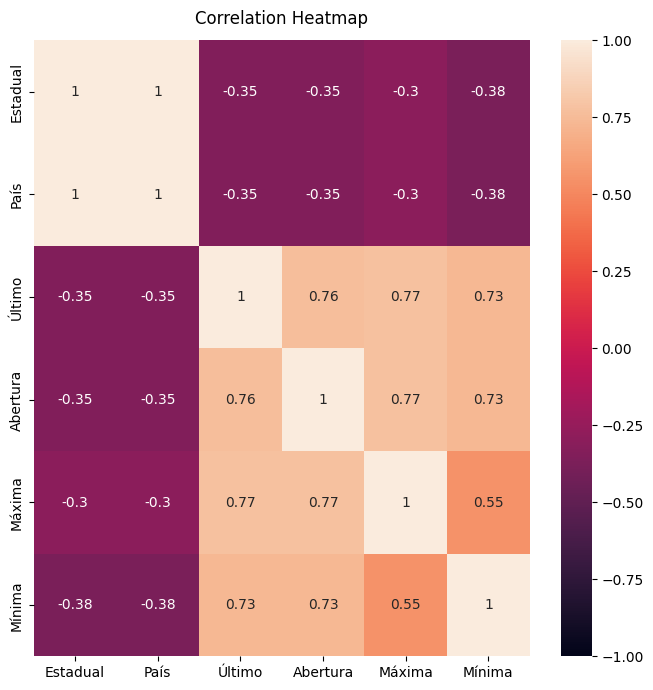

In [6]:
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(df[["Estadual", "País", "Último", "Abertura", "Máxima", "Mínima"]].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [7]:
train_size = 0.8
test_size = 0.2

train_start = df.Data[0]
train_end = df.Data[int(len(df)*0.8)]

test_start = df.Data[int(len(df)*0.8)]
test_end = df.Data[len(df)-1]

print(train_start)
print(train_end)
print(test_start)
print(test_end)


2004-03-01
2020-08-01
2020-08-01
2024-09-01


Linear Regression

In [8]:
from sklearn.model_selection import train_test_split
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression

In [24]:
df1 = df.copy()

df1['Data'] = pd.to_datetime(df1['Data'])
df1["Time"] = df.index

train_df = df1[:(int(len(df1)*0.8))].copy()
test_df = df1[(int(len(df1)*0.8)+1):].copy()

In [28]:
X = df1.loc[:, ['Time']]  # features
y = df1.loc[:, 'Estadual']  # target

In [29]:
# Train the model
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

AutoRegressive

In [12]:
df1 = df.copy()

df1['Data'] = pd.to_datetime(df1['Data'])
df1.set_index('Data', inplace = True)
df1.dropna(inplace=True)
df1 = df1.asfreq('ME', method = 'bfill') 
df1 = df1[["Estadual", "País"]]

train_df = df1[:(int(len(df1)*0.8))].copy()
test_df = df1[(int(len(df1)*0.8)+1):].copy()

display(df1)

,Estadual,País
Data,,
2004-03-31,45.9456,48.7279
2004-04-30,44.8723,47.4930
2004-05-31,38.5913,40.7781
2004-06-30,34.0818,37.5474
2004-07-31,31.8333,34.9411
...,...,...
2024-04-30,114.0022,118.2335
2024-05-31,118.9727,121.3981
2024-06-30,120.0369,121.7345


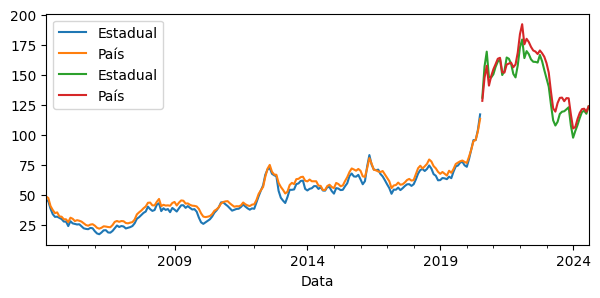

In [13]:
fig, ax = plt.subplots(figsize=(7, 3))
df1.loc[train_start:train_end].plot(ax=ax, label = "Train")
df1.loc[test_start:test_end].plot(ax=ax, label = "Test")
ax.legend()

Test MAE: 38.905
Test RMSE: 47.026


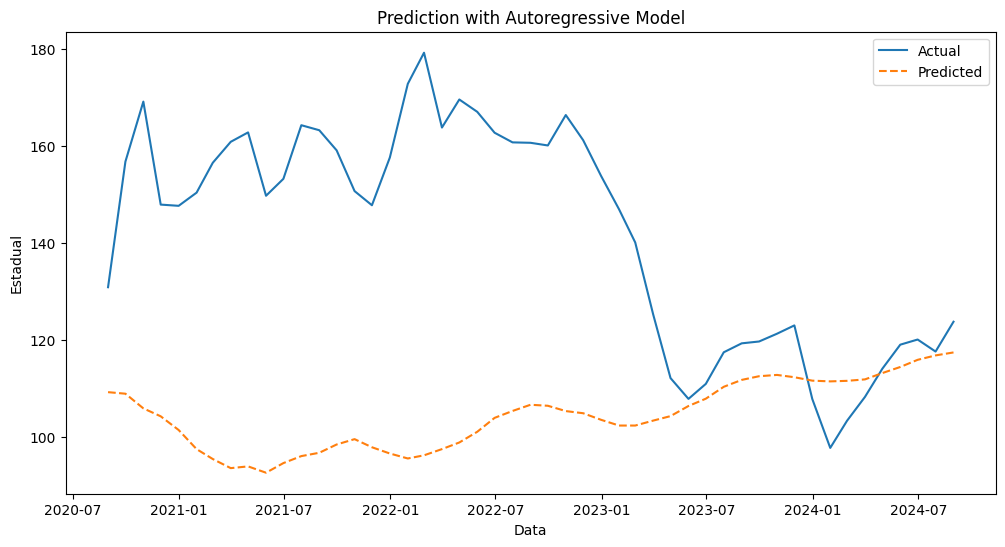

In [14]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# split dataset
X = df1[["Estadual"]].values
train = train_df["Estadual"]
test = test_df["Estadual"]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
# print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
#     print('predicted=%f, expected=%f' % (predictions[i], test[i]))

test_df["Data"] = test_df.index

mae = mean_absolute_error(test, predictions)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)


plt.figure(figsize=(12, 6))
plt.plot(test_df["Data"], test, label='Actual')
plt.plot(test_df["Data"], predictions, label='Predicted', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Estadual')
plt.legend()
plt.title('Prediction with Autoregressive Model')
plt.show()

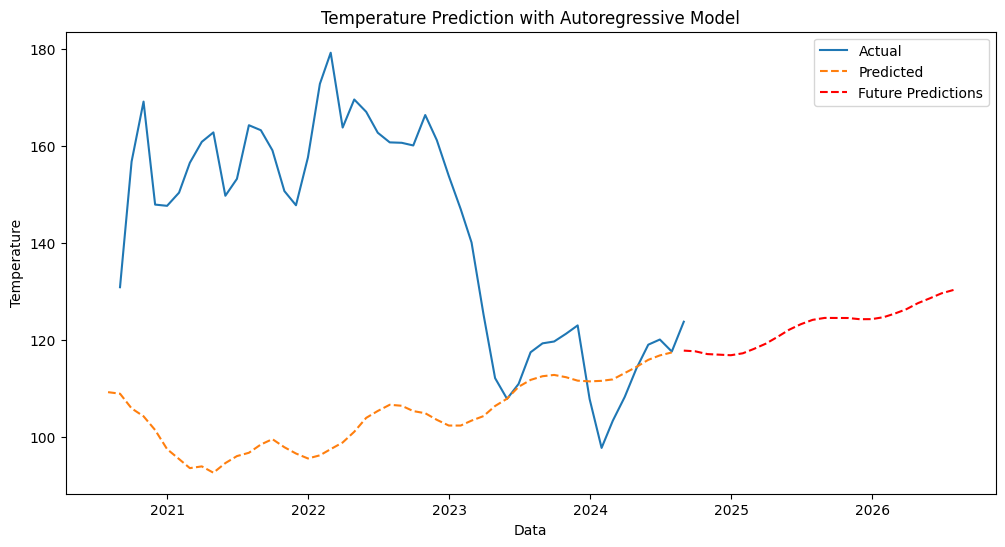

In [15]:
# Define the number of future time steps you want to predict (1 week)
forecast_steps = 24
 
# Extend the predictions into the future for one year
future_indices = range(len(test_df), len(test_df) + forecast_steps)
future_predictions = model_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) + forecast_steps - 1, dynamic=False)

# Create date indices for the future predictions
future_dates = pd.date_range(start=test_df['Data'].iloc[-1], periods=forecast_steps, freq='ME')
 
# Plot the actual data, existing predictions, and one year of future predictions
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='--')
plt.plot(future_dates, future_predictions[-forecast_steps:], label='Future Predictions', linestyle='--', color='red')
plt.xlabel('Data')
plt.ylabel('Temperature')
plt.legend()
plt.title('Temperature Prediction with Autoregressive Model')
plt.show()

In [16]:
future_predictions[-forecast_steps:]

2024-08-31    117.748252
2024-09-30    117.598584
2024-10-31    117.031586
2024-11-30    116.912677
2024-12-31    116.791994
2025-01-31    117.191302
2025-02-28    118.075309
2025-03-31    119.161214
2025-04-30    120.534945
2025-05-31    122.058809
2025-06-30    123.192528
2025-07-31    124.103496
2025-08-31    124.501688
2025-09-30    124.490258
2025-10-31    124.481411
2025-11-30    124.235999
2025-12-31    124.251080
2026-01-31    124.656820
2026-02-28    125.373288
2026-03-31    126.307839
2026-04-30    127.558972
2026-05-31    128.562561
2026-06-30    129.584230
2026-07-31    130.280087
Freq: ME, dtype: float64

ARMA & ARIMA

In [ ]:
#Import libraries 
import inspect
import time
import warnings
import plotly.express as px
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

In [69]:
df2 = df.copy()

df2['Data'] = pd.to_datetime(df2['Data'])
df2.set_index('Data', inplace = True)
df2.dropna(inplace=True)
#df2 = df2.asfreq('ME', method = 'bfill') 
df2 = df2[["Estadual"]]

train_df = df2[:(int(len(df2)*0.8))].copy()
test_df = df2[(int(len(df2)*0.8)+1):].copy()

display(df2)

,Estadual
Data,
2004-03-01,45.3777
2004-04-01,45.9456
2004-05-01,44.8723
2004-06-01,38.5913
2004-07-01,34.0818
...,...
2024-05-01,114.0022
2024-06-01,118.9727
2024-07-01,120.0369


In [70]:
y = df2.copy()